Author: Doğu Can ELÇİ, MS Student at Istanbul Technical University

# <h style= "color:red;font-size:50px">NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN,Custom-RNN,CNN and Bi-LSTM</h>

<l style="font-size:30 px;">In this project, approximately 20 thousand tagged names from 18 languages were trained on a character basis using 8 different models, different batch-sizes and embedding-layers, and the results were shown.</l><br>
<br><l style="font-size:30px;font-weight:bold">Used models:</l><br><br>
<strong>1- Include Embedding Layer:</strong><br>

•&nbsp;CNN | batch-sizes: [128,64,32,16,8]<br>
•&nbsp;bi-LSTM | batch-sizes: [128,64,32,16,8]<br>
•&nbsp;nn.RNN | batch-sizes: [128,64,32,16,8]<br>
•&nbsp;Customized-RNN | batch-sizes: [128]<br>
<br>
<strong>2- Without Embedding Layer:</strong><br><br>
•&nbsp; CNN | batch-sizes: [128,64,32,16,8]<br>
•&nbsp;bi-LSTM | batch-sizes: [128,64,32,16,8]<br>
•&nbsp;nn.RNN | batch-sizes: [128,64,32,16,8]<br>
•&nbsp;Customized-RNN | batch-sizes: [128]<br>


# 1- Data Reading

In [1]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-" #All upper and lower characters and some punctiations are added in all_letters.
                                              #Last character(-) will use as a padding char.
n_letters = len(all_letters)    #number of total letters

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s): # It converts some stranger characters to most similar latin letters.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))  #For example in this name: Ś --> S

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories) #number of languages

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
import torch

# 2-Preprocessing

In [3]:
#Returns an index number as location of any letter in all_letters | Example: letter2index('a') -> 0
def letter2index(letter):
    letter = unicodeToAscii(letter)
    return all_letters.find(letter)

In [4]:
#Returns an one-hot encoding tensor letter index is 1 and others are 0.(tensor size: 1,n_letters)
def letter2tensor(letter):
    idx = letter2index(letter)
    torch_vec = torch.zeros(n_letters)
    torch_vec[idx] = 1
    return torch_vec

In [5]:
#Returns a tensor which include one-hot-encoded letter tensors inside.(tensor size: 1,name_length,n_letters)
def name2tensor(name):
    name_letter_tensor = torch.zeros(1,len(name),n_letters)
    for idx,letter in enumerate(name):
        name_letter_tensor[0][idx][letter2index(letter)] = 1
    return name_letter_tensor

In [6]:
name2tensor('Ali').size()

torch.Size([1, 3, 58])

In [7]:
#Assign a number to each language category
def category_encoder(categories):
    category_dict = {x:idx for idx,x in enumerate(categories)}
    return category_dict

In [8]:
category_dict = category_encoder(category_lines.keys())
category_dict

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

In [9]:
#Return total counts of each language category
def get_category_counts(category_dict):
    category_count_dict = {category:len(category_lines[category]) for category in category_dict.keys()}
    return category_count_dict

In [10]:
#Total counts of languages
category_counts_dict = get_category_counts(category_dict)
category_counts_dict

{'Arabic': 2000,
 'Chinese': 268,
 'Czech': 519,
 'Dutch': 297,
 'English': 3668,
 'French': 277,
 'German': 724,
 'Greek': 203,
 'Irish': 232,
 'Italian': 709,
 'Japanese': 991,
 'Korean': 94,
 'Polish': 139,
 'Portuguese': 74,
 'Russian': 9384,
 'Scottish': 100,
 'Spanish': 298,
 'Vietnamese': 73}

In [11]:
#Sort total counts for each category and assign a dict
category_counts_sorted = dict(sorted(category_counts_dict.items(), key=lambda x: x[1],reverse=True)) 

<l style= font-size:20px>As we can see below, Russian,English and Arabic are more than others as number.</l>

<BarContainer object of 18 artists>

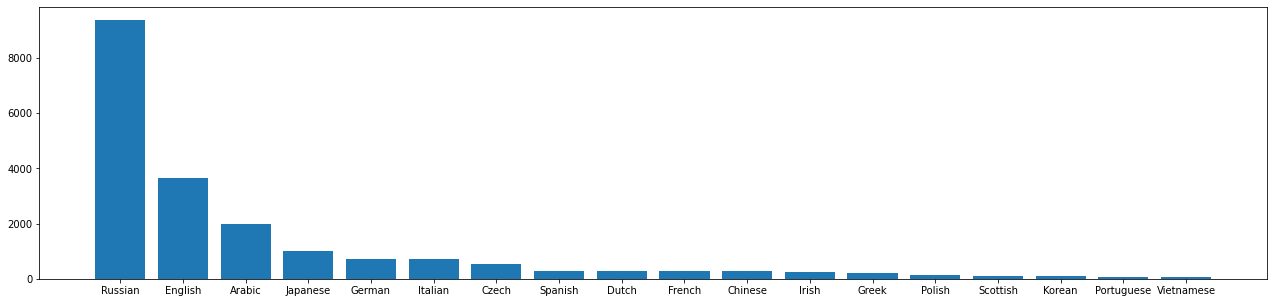

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(22,5))
plt.bar(category_counts_sorted.keys(),category_counts_sorted.values())

<l style= "font-size:20px">Longest name has 20 char inside.</l>

In [13]:
#get the longest name in all names from all categories
flatten_name_list = sum([name for name in category_lines.values()],[])
max_name_size = sorted([len(name) for name in flatten_name_list])[-1]
max_name_size

20

# 3- Dataset Creating

In [14]:
total_name_size = sum(category_counts_sorted.values()) # total name number: 20050
X_tensor = [] #Include all one-hot-encoded name tensors 
y_tensor = [] #Include all name category numb tensors (target)
for category in category_lines.keys():
    for idx,name in enumerate(category_lines[category]): #This loop is used for make names a fixed size for fixed hidden layer sizes in nn.
        name = name + '-'*(20 - len(name)) # padding char is selected as '-'.
        X_tensor.append(name2tensor(name))
        y_tensor.append(torch.tensor(category_dict[category]).view(1,))
len(X_tensor)

20050

In [15]:
X_tensor_reshaped = torch.concat(X_tensor, dim=0) #list to tensor
X_tensor_reshaped.size()

torch.Size([20050, 20, 58])

In [16]:
y_tensor_reshaped = torch.concat(y_tensor,dim=0) #list to tensor
y_tensor_reshaped.size()

torch.Size([20050])

In [17]:
#Feature and target tensors are splited as train and test set as rate %10.
from sklearn.model_selection import train_test_split
X_train, X_test , y_train ,y_test = train_test_split(X_tensor_reshaped.numpy(),y_tensor_reshaped.numpy(),test_size=0.1,random_state=42,stratify=y_tensor_reshaped.numpy())

In [18]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((18045, 20, 58), (2005, 20, 58), (18045,), (2005,))

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [20]:
#Train and test samples are splited as batch_size for preparing to training and testing.
def train_test_loader(X_train,y_train,X_test,y_test,batch_size):
    train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size,drop_last=True)

    valid_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size,drop_last=True)
    return train_loader,valid_loader

In [21]:
#This is global variable for embedding layer size for all models.
EMBED_SIZE = 10 

# 4- Model Creating

In [22]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
    self.in2output = nn.Linear(hidden_size + hidden_size, n_categories)

  def forward(self, x, hidden_state):
    #print("x: ", x.shape)  # x: torch.Size([128, 20, 58]) | (batch_size, seq_len, features)
    #hidden_state[0].size() -> hidden_h0: torch.Size([2, 128, 128])
    #hidden_state[1].size() -> hidden_c0: torch.Size([2, 128, 128])
    # 128 + 128 because it is bi-directional model !
    # c0(cell state) + h0(hidden state) --> 128 (combined by nn.LSTM just like nn.RNN)
    output, hidden_state = self.lstm(x, hidden_state) #output.size() -> torch.Size([128, 20, 256])(128 short + 128 long)
                                                      #hidden_state[0].size() -> hidden_h0: torch.Size([2, 128, 128])
                                                      #hidden_state[1].size() -> hidden_c0: torch.Size([2, 128, 128])
    output = self.in2output(output[:, -1, :]) #last char embed of name include all information of previous ones.
                                              #output.size() -> 128,256(128 short + 128 long)
    return output

  def init_hidden(self, batch_size):
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros(self.num_layers*2,batch_size,self.hidden_size)
    c0 = torch.zeros(self.num_layers*2,batch_size,self.hidden_size)
    hidden = (h0,c0)
    return hidden

In [23]:
class LSTMModel_Embed(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTMModel_Embed, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.embed = nn.Embedding(input_size, EMBED_SIZE)
    self.lstm = nn.LSTM(input_size = EMBED_SIZE, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
    self.in2output = nn.Linear(hidden_size + hidden_size, n_categories)

  def forward(self, x, hidden_state):

    argmax_x = torch.argmax(x,dim=2)
    embed = self.embed(argmax_x)
    output, hidden_state = self.lstm(embed, hidden_state)

    output = self.in2output(output[:, -1, :]) #last char embed of name include all information of previous ones.
    return output

  def init_hidden(self, batch_size):
    # Initialization two new tensors which are cell and hidden state.
    h0 = torch.zeros(self.num_layers*2,batch_size,self.hidden_size)
    c0 = torch.zeros(self.num_layers*2,batch_size,self.hidden_size)
    hidden = (h0,c0)
    return hidden

In [24]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(RNNModel, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn1 = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
    self.in2output = nn.Linear(hidden_size, n_categories)

  def forward(self, x, hidden_state):
    # 128 + 128 her türlü 256 olmak zorunda !!! *** 
    output, hidden_state = self.rnn1(x, hidden_state) # nn.RNN module combines 58 and 128 somehow and output size is also 128.
    output = self.in2output(output[:, -1, :]) #last char embed of name include all information of previous ones.
    return output

  def init_hidden(self, batch_size):
    h0 = torch.zeros(self.num_layers,batch_size,self.hidden_size)
    hidden = h0
    return hidden

In [25]:
class RNNModel_Embed(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(RNNModel_Embed, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.embed = nn.Embedding(input_size, EMBED_SIZE)
    self.rnn1 = nn.RNN(input_size = EMBED_SIZE, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
    self.in2output = nn.Linear(hidden_size, n_categories)

  def forward(self, x, hidden_state):

    # 128 + 128 her türlü 256 olmak zorunda !!! *** 
    x_argmax = torch.argmax(x,dim=2)   #one_hot to index vector | torch.Size([128, 20, 58]) --> torch.Size([128, 20])    
    embed = self.embed(x_argmax)       #embedded.size() --> torch.Size([128, 20, 10])
    output, hidden_state = self.rnn1(embed, hidden_state)

    output = self.in2output(output[:, -1, :]) #last char embed of name include all information of previous ones.

    return output

  def init_hidden(self, batch_size):
    # initialization of new hidden state tensor
    h0 = torch.zeros(self.num_layers,batch_size,self.hidden_size)
    hidden = h0
    return hidden

In [26]:
import torch.nn as nn

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        combined1 = torch.cat((input,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [27]:
import torch.nn as nn

class CustomRNN_Embed(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNN_Embed, self).__init__()
        self.hidden_size = hidden_size
        #self.vocab_size = vocab_size
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        x_argmax = torch.argmax(input,dim=0)
        embeds = self.embed(x_argmax)
        combined1 = torch.cat((embeds,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [28]:
from torch import nn
from torch.nn import functional as F
class CNNModel(nn.Module):
    def __init__(self,input_size, n_filters, filter_sizes):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size,n_filters, kernel_size=filter_sizes, padding='same') #(58,20) --> (4,20) | padding: return same size
        self.pool = nn.MaxPool1d(kernel_size=2) #(4,20) --> (4,10)
        self.fc1 = nn.Linear(n_filters*10, n_categories) #size of output linear layer has to assign manually before.
                                                         # 40 -> 18
    def forward(self, x):
        x = x.permute(0, 2, 1) #torch.Size([128, 20, 58]) --> torch.Size([128, 58, 20])
        conved = F.relu(self.conv1(x)) #Mapping with Convolutional layer and activated with ReLu | conved.size()-->torch.Size([128, 4, 20])
        pooled = self.pool(conved)  #decrease matrix size with selection of max cells | torch.Size([128, 4, 20]) --> torch.Size([128, 4, 10])
        x = torch.flatten(pooled,1) # make array to 1d | x.size() --> torch.Size([128, 40])
        x = F.relu(self.fc1(x)) #1d flatted-input activated with ReLu
        return x

In [29]:
from torch import nn
from torch.nn import functional as F
class CNNModel_Embed(nn.Module):
    def __init__(self,input_size, n_filters, filter_sizes):
        super().__init__()
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #(max_name_size,n_letters) --> (max_name_size,embedded_size)
                                                          #(20,58) --> (20,10)
        self.conv1 = nn.Conv1d(EMBED_SIZE,n_filters, kernel_size=filter_sizes, padding='same') #(58,20) --> (4,20) | padding: return same size
        self.pool = nn.MaxPool1d(kernel_size=2) #(4,20) --> (4,10)
        self.fc1 = nn.Linear(n_filters*10, n_categories) #size of output linear layer has to assign manually before.
                                                         # 40 -> 18

    def forward(self, x):
        x_argmax = torch.argmax(x,dim=2)     #one_hot to index vector | torch.Size([128, 20, 58]) --> torch.Size([128, 20])
        embedded = self.embed(x_argmax)      #embedded.size() --> torch.Size([128, 20, 10])
        embedded = embedded.permute(0, 2, 1) #torch.Size([128, 20, 10]) --> torch.Size([128, 10, 20])
        conved = F.relu(self.conv1(embedded)) #Mapping with Convolutional layer and activated with ReLu | conved.size()-->torch.Size([128, 4, 20])
        pooled = self.pool(conved) #decrease matrix size with selection of max cells | torch.Size([128, 4, 20]) --> torch.Size([128, 4, 10])
        x = torch.flatten(pooled,1) # make array to 1d | x.size() --> torch.Size([128, 40])
        x = F.relu(self.fc1(x)) # 1d flatted-input activated with ReLu
        return x

In [30]:
# Return loss function(CrossEntropyLoss), model(nn.CNN) with or without Embedding layer and optimizer function(Adam Optimizer) 
def create_cnn_model(is_embedding = False):
    n_filters = 4 #number of filters
    filter_size = 2 # 1d filter progress with 2 window-size (for this project,2 char)
    learning_rate = 0.001 #step size of current update process of weights
    epochs =  10 #number of updating process with all training samples
    if is_embedding: #CNN model with Embedding layer
        model = CNNModel_Embed(n_letters , n_filters, filter_size)
    else:  #CNN model without Embedding layer
        model = CNNModel(n_letters , n_filters, filter_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # defining loss function
    loss_func = nn.CrossEntropyLoss()

    return model,optimizer,loss_func,epochs

In [31]:
# Return loss function(CrossEntropyLoss), model(nn.LSTM) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_lstm_model(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 10
    if is_embedding:  #LSTM model with Embedding layer
        model = LSTMModel_Embed(n_letters , hidden_size, 1)
    else:  #LSTM model without Embedding layer
        model = LSTMModel(n_letters , hidden_size, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # defining loss function
    loss_func = nn.CrossEntropyLoss()
    #loss_fn = nn.NLLLoss()
    return model,optimizer,loss_func,epochs

In [32]:
# Return loss function(CrossEntropyLoss), model(nn.RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 10
    if is_embedding:  #nn.RNN model with Embedding layer
        model = RNNModel_Embed(n_letters , hidden_size, 1)
    else:  #nn.RNN model with Embedding layer
        model = RNNModel(n_letters , hidden_size, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # defining loss function
    loss_func = nn.CrossEntropyLoss()
    #loss_fn = nn.NLLLoss()
    return model,optimizer,loss_func,epochs

In [33]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_custom_rnn_model(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 10
    if is_embedding:  #Customized RNN model with Embedding layer
        model = CustomRNN_Embed(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = CustomRNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [34]:
def accuracy_2(pred,label): #Return how much true label match with predictions(max prob. class index)
    return torch.sum(torch.argmax(pred,dim=1) == label).item()

# 5- Training and Evaluation

In [35]:
def cnn_train_test_process(has_embedding=False):

  batch_list = [128,64,16,8]
  main_accuracy_dict = {} #accuracy dict (keys: batch_sizes, values: accuracy)
  for batch_i in batch_list:
    #model,optimizer_128,loss_func = create_model()
    model,optimizer_128,loss_func,epochs = create_cnn_model(has_embedding)
    batch_size = batch_i #current batch-size
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size) #preparing train and test datasets
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs): #epoch-i
      total_train_loss = 0
      for batch in (train_loader): #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad()
        # forward process according to batch-size
        outputs1 = model(batch[0])
        # computing training loss
        loss = loss_func(outputs1, batch[1])
        total_train_loss += loss.item()
        # backward process according to batch-size
        loss.backward()
        # updating parameters
        optimizer_128.step()

      # calculating average train loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = [] #validation accuracy list
      val_loss = [] #validation loss list
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            pred = model(batch[0])
        # computing loss
        loss = loss_func(outputs1, batch[1])
        val_loss.append(loss.item())
  #Validation process
        acc = accuracy_2(pred,batch[1])
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)

      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict

In [36]:
def lstm_train_test_process(has_embedding=False):

  batch_list = [128,64,16,8]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    model,optimizer_128,loss_func,epochs = create_lstm_model(has_embedding)
    batch_size = batch_i
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad()
        # performing forward pass
        init_hidden = model.init_hidden(batch_size)
        #logits = model(b_input_ids,init_hidden)
        outputs1 = model(batch[0],init_hidden)
        # computing loss
        loss = loss_func(outputs1, batch[1])
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)


      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden(batch_size)
            pred = model(batch[0],init_hidden)
        # computing loss
        loss = loss_func(outputs1, batch[1])
        val_loss.append(loss.item())
  #Validation process
        acc = accuracy_2(pred,batch[1])
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)

      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict

In [37]:
def rnn_train_test_process(has_embedding=False):
  batch_list = [128,64,16,8]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    model,optimizer,loss_func,epochs = create_rnn_model(has_embedding)
    batch_size = batch_i
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad()
        # performing forward pass
        init_hidden = model.init_hidden(batch_size) # init_hidden.size() --> torch.Size([1, 64, 128]) (hidden_layer_num,batch_size,hidden_size)
        #outputs1 = model(b_input_ids,init_hidden)
        outputs1 = model(batch[0],init_hidden)
        # computing loss
        loss = loss_func(outputs1, batch[1])
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)


      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden(batch_size)
            pred = model(batch[0],init_hidden)
        # computing loss
        loss = loss_func(outputs1, batch[1])
        val_loss.append(loss.item())
  #Validation process
        acc = accuracy_2(pred,batch[1])
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict

In [38]:
def custom_rnn_train_test_process(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_custom_rnn_model(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden
        outputs1_tensor = torch.zeros(batch_size,n_categories)
        for idx,name in enumerate(batch[0]):
          for char in name:
            outputs1,hidden = model(char,hidden)
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor, batch[1])
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories)
            for idx,name in enumerate(batch[0]):
              for char in name:
                outputs1,hidden = model(char,hidden)
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor, batch[1])
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor,batch[1])
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict

In [39]:
lstm_dict_embed = lstm_train_test_process(has_embedding=True)
lstm_dict_embed

Epoch no: 1 | Train_loss: 1.9112 | Val_loss: 1.84974 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84737 | Val_loss: 1.84811 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.59658 | Val_loss: 2.56808 | Val_Accuracy: 0.56
Epoch no: 4 | Train_loss: 1.43379 | Val_loss: 2.70626 | Val_Accuracy: 0.6
Epoch no: 5 | Train_loss: 1.32368 | Val_loss: 2.83209 | Val_Accuracy: 0.64
Epoch no: 6 | Train_loss: 1.23472 | Val_loss: 3.02704 | Val_Accuracy: 0.65
Epoch no: 7 | Train_loss: 1.16008 | Val_loss: 3.09695 | Val_Accuracy: 0.69
Epoch no: 8 | Train_loss: 1.0473 | Val_loss: 3.40978 | Val_Accuracy: 0.72
Epoch no: 9 | Train_loss: 0.94523 | Val_loss: 3.47285 | Val_Accuracy: 0.74
Epoch no: 10 | Train_loss: 0.87628 | Val_loss: 3.66282 | Val_Accuracy: 0.75
Best accuracy is : %74.63541666666667 for batch_size =128
Epoch no: 1 | Train_loss: 1.88883 | Val_loss: 1.84457 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.61447 | Val_loss: 2.3895 | Val_Accuracy: 0.58
Epoch no: 3 | Train_loss: 1.39768 | Val_loss:

{128: 0.7463541666666667, 64: 0.7832661290322581, 16: 0.793, 8: 0.7755}

In [40]:
lstm_dict = lstm_train_test_process(has_embedding=False)
lstm_dict

Epoch no: 1 | Train_loss: 1.94543 | Val_loss: 1.84957 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84775 | Val_loss: 1.8494 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.84762 | Val_loss: 1.84905 | Val_Accuracy: 0.47
Epoch no: 4 | Train_loss: 1.84747 | Val_loss: 1.84864 | Val_Accuracy: 0.47
Epoch no: 5 | Train_loss: 1.8473 | Val_loss: 1.84822 | Val_Accuracy: 0.47
Epoch no: 6 | Train_loss: 1.84705 | Val_loss: 1.84784 | Val_Accuracy: 0.47
Epoch no: 7 | Train_loss: 1.75953 | Val_loss: 2.24334 | Val_Accuracy: 0.54
Epoch no: 8 | Train_loss: 1.48136 | Val_loss: 2.5517 | Val_Accuracy: 0.56
Epoch no: 9 | Train_loss: 1.37942 | Val_loss: 2.90325 | Val_Accuracy: 0.63
Epoch no: 10 | Train_loss: 1.21376 | Val_loss: 3.12367 | Val_Accuracy: 0.66
Best accuracy is : %66.35416666666667 for batch_size =128
Epoch no: 1 | Train_loss: 1.90013 | Val_loss: 1.84475 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84884 | Val_loss: 1.84428 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.84831 | Val_loss

{128: 0.6635416666666667, 64: 0.7373991935483871, 16: 0.7865, 8: 0.7975}

In [41]:
cnn_dict_embed = cnn_train_test_process(has_embedding=True)
cnn_dict_embed

C:\Users\doguc\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch no: 1 | Train_loss: 2.15433 | Val_loss: 1.90775 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.76741 | Val_loss: 2.06209 | Val_Accuracy: 0.49
Epoch no: 3 | Train_loss: 1.59209 | Val_loss: 2.28754 | Val_Accuracy: 0.57
Epoch no: 4 | Train_loss: 1.48846 | Val_loss: 2.46273 | Val_Accuracy: 0.61
Epoch no: 5 | Train_loss: 1.43235 | Val_loss: 2.58502 | Val_Accuracy: 0.62
Epoch no: 6 | Train_loss: 1.39461 | Val_loss: 2.6686 | Val_Accuracy: 0.63
Epoch no: 7 | Train_loss: 1.36629 | Val_loss: 2.72721 | Val_Accuracy: 0.65
Epoch no: 8 | Train_loss: 1.34279 | Val_loss: 2.77863 | Val_Accuracy: 0.65
Epoch no: 9 | Train_loss: 1.32294 | Val_loss: 2.82391 | Val_Accuracy: 0.65
Epoch no: 10 | Train_loss: 1.30589 | Val_loss: 2.86511 | Val_Accuracy: 0.65
Best accuracy is : %65.36458333333334 for batch_size =128
Epoch no: 1 | Train_loss: 2.12655 | Val_loss: 2.0888 | Val_Accuracy: 0.49
Epoch no: 2 | Train_loss: 1.7843 | Val_loss: 2.29548 | Val_Accuracy: 0.53
Epoch no: 3 | Train_loss: 1.67731 | Val_loss

{128: 0.6536458333333334, 64: 0.6123991935483871, 16: 0.6255, 8: 0.629}

In [42]:
cnn_dict = cnn_train_test_process(has_embedding=False)
cnn_dict

Epoch no: 1 | Train_loss: 2.4812 | Val_loss: 1.92425 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.87832 | Val_loss: 1.93447 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.78449 | Val_loss: 2.00018 | Val_Accuracy: 0.47
Epoch no: 4 | Train_loss: 1.69302 | Val_loss: 2.1008 | Val_Accuracy: 0.5
Epoch no: 5 | Train_loss: 1.62001 | Val_loss: 2.19069 | Val_Accuracy: 0.56
Epoch no: 6 | Train_loss: 1.55053 | Val_loss: 2.26896 | Val_Accuracy: 0.59
Epoch no: 7 | Train_loss: 1.49251 | Val_loss: 2.35082 | Val_Accuracy: 0.6
Epoch no: 8 | Train_loss: 1.45453 | Val_loss: 2.42348 | Val_Accuracy: 0.62
Epoch no: 9 | Train_loss: 1.42683 | Val_loss: 2.48707 | Val_Accuracy: 0.62
Epoch no: 10 | Train_loss: 1.40534 | Val_loss: 2.5432 | Val_Accuracy: 0.63
Best accuracy is : %62.96874999999999 for batch_size =128
Epoch no: 1 | Train_loss: 2.80057 | Val_loss: 2.79407 | Val_Accuracy: 0.18
Epoch no: 2 | Train_loss: 2.7362 | Val_loss: 2.81659 | Val_Accuracy: 0.18
Epoch no: 3 | Train_loss: 2.69811 | Val_loss: 2

{128: 0.6296875, 64: 0.5806451612903226, 16: 0.6635, 8: 0.5725}

In [43]:
rnn_dict_embed = rnn_train_test_process(has_embedding=True)
rnn_dict_embed

Epoch no: 1 | Train_loss: 1.89296 | Val_loss: 1.8519 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84997 | Val_loss: 1.85176 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.84967 | Val_loss: 1.85132 | Val_Accuracy: 0.47
Epoch no: 4 | Train_loss: 1.84935 | Val_loss: 1.8508 | Val_Accuracy: 0.47
Epoch no: 5 | Train_loss: 1.84908 | Val_loss: 1.85033 | Val_Accuracy: 0.47
Epoch no: 6 | Train_loss: 1.84887 | Val_loss: 1.84999 | Val_Accuracy: 0.47
Epoch no: 7 | Train_loss: 1.84867 | Val_loss: 1.84966 | Val_Accuracy: 0.47
Epoch no: 8 | Train_loss: 1.84849 | Val_loss: 1.84974 | Val_Accuracy: 0.47
Epoch no: 9 | Train_loss: 1.84836 | Val_loss: 1.84928 | Val_Accuracy: 0.47
Epoch no: 10 | Train_loss: 1.84823 | Val_loss: 1.84883 | Val_Accuracy: 0.47
Best accuracy is : %46.875 for batch_size =128
Epoch no: 1 | Train_loss: 1.87653 | Val_loss: 1.84923 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.85253 | Val_loss: 1.84829 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.85169 | Val_loss: 1.8469 |

{128: 0.46875, 64: 0.47026209677419356, 16: 0.647, 8: 0.482}

In [44]:
rnn_dict = rnn_train_test_process(has_embedding=False)
rnn_dict

Epoch no: 1 | Train_loss: 1.9038 | Val_loss: 1.85123 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84974 | Val_loss: 1.85099 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.84952 | Val_loss: 1.85082 | Val_Accuracy: 0.47
Epoch no: 4 | Train_loss: 1.84924 | Val_loss: 1.85063 | Val_Accuracy: 0.47
Epoch no: 5 | Train_loss: 1.849 | Val_loss: 1.8505 | Val_Accuracy: 0.47
Epoch no: 6 | Train_loss: 1.8488 | Val_loss: 1.85042 | Val_Accuracy: 0.47
Epoch no: 7 | Train_loss: 1.84863 | Val_loss: 1.85032 | Val_Accuracy: 0.47
Epoch no: 8 | Train_loss: 1.84847 | Val_loss: 1.85031 | Val_Accuracy: 0.47
Epoch no: 9 | Train_loss: 1.84833 | Val_loss: 1.85022 | Val_Accuracy: 0.47
Epoch no: 10 | Train_loss: 1.84823 | Val_loss: 1.84981 | Val_Accuracy: 0.47
Best accuracy is : %46.875 for batch_size =128
Epoch no: 1 | Train_loss: 1.88061 | Val_loss: 1.84803 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.85284 | Val_loss: 1.84776 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.85217 | Val_loss: 1.84736 | V

{128: 0.46875, 64: 0.47026209677419356, 16: 0.5715, 8: 0.4735}

In [45]:
rnn_custom_dict_embed = custom_rnn_train_test_process(has_embedding=True)
rnn_custom_dict_embed

Epoch no: 1 | Train_loss: 1.87666 | Val_loss: 1.85373 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84497 | Val_loss: 1.82604 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.72127 | Val_loss: 1.59909 | Val_Accuracy: 0.53
Epoch no: 4 | Train_loss: 1.57468 | Val_loss: 1.54572 | Val_Accuracy: 0.54
Epoch no: 5 | Train_loss: 1.523 | Val_loss: 1.50194 | Val_Accuracy: 0.56
Epoch no: 6 | Train_loss: 1.47818 | Val_loss: 1.44208 | Val_Accuracy: 0.59
Epoch no: 7 | Train_loss: 1.45263 | Val_loss: 1.44767 | Val_Accuracy: 0.59
Epoch no: 8 | Train_loss: 1.40381 | Val_loss: 1.34322 | Val_Accuracy: 0.61
Epoch no: 9 | Train_loss: 1.37887 | Val_loss: 1.33811 | Val_Accuracy: 0.61
Epoch no: 10 | Train_loss: 1.33646 | Val_loss: 1.29381 | Val_Accuracy: 0.61
Best accuracy is : %60.9375 for batch_size =128


{128: 0.609375}

In [46]:
rnn_custom_dict = custom_rnn_train_test_process(has_embedding=False)
rnn_custom_dict

Epoch no: 1 | Train_loss: 1.91467 | Val_loss: 1.80823 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.82411 | Val_loss: 1.83959 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 1.75514 | Val_loss: 1.56368 | Val_Accuracy: 0.51
Epoch no: 4 | Train_loss: 1.5274 | Val_loss: 1.4769 | Val_Accuracy: 0.55
Epoch no: 5 | Train_loss: 1.48404 | Val_loss: 1.48919 | Val_Accuracy: 0.55
Epoch no: 6 | Train_loss: 1.46543 | Val_loss: 1.47847 | Val_Accuracy: 0.54
Epoch no: 7 | Train_loss: 1.44881 | Val_loss: 1.45877 | Val_Accuracy: 0.56
Epoch no: 8 | Train_loss: 1.43498 | Val_loss: 1.43826 | Val_Accuracy: 0.56
Epoch no: 9 | Train_loss: 1.42354 | Val_loss: 1.42047 | Val_Accuracy: 0.56
Epoch no: 10 | Train_loss: 1.41049 | Val_loss: 1.39065 | Val_Accuracy: 0.55
Best accuracy is : %55.93749999999999 for batch_size =128


{128: 0.559375}

In [87]:
lstm_list_embed = [['lstm_embed' + str(i),(lstm_dict_embed[i])] for i in list(lstm_dict_embed.keys())]
lstm_list = [['lstm_' + str(i),lstm_dict[i]] for i in list(lstm_dict.keys())]

rnn_list_embed = [['rnn_embed' + str(i),rnn_dict_embed[i]] for i in list(rnn_dict_embed.keys())]
rnn_list = [['rnn_' + str(i),rnn_dict[i]] for i in list(rnn_dict.keys())]

rnn_custom_list_embed = [['rnn_custom_embed' + str(i),rnn_custom_dict_embed[i]] for i in list(rnn_custom_dict_embed.keys())]
rnn_custom_list = [['rnn_custom_' + str(i),rnn_custom_dict[i]] for i in list(rnn_custom_dict.keys())]

cnn_list_embed = [['cnn_embed' + str(i),cnn_dict_embed[i]] for i in list(cnn_dict_embed.keys())]
cnn_list = [['cnn_' + str(i),cnn_dict[i]] for i in list(cnn_dict.keys())]

In [88]:
total_list = lstm_list_embed + lstm_list + rnn_list_embed + rnn_list + rnn_custom_list_embed + rnn_custom_list + cnn_list_embed + cnn_list

In [95]:
total_list.sort(key=lambda x:x[1])
total_list = total_list[::-1]
total_list

[['lstm_8', 0.7975],
 ['lstm_embed16', 0.793],
 ['lstm_16', 0.7865],
 ['lstm_embed64', 0.7832661290322581],
 ['lstm_embed8', 0.7755],
 ['lstm_embed128', 0.7463541666666667],
 ['lstm_64', 0.7373991935483871],
 ['lstm_128', 0.6635416666666667],
 ['cnn_16', 0.6635],
 ['cnn_embed128', 0.6536458333333334],
 ['rnn_embed16', 0.647],
 ['cnn_128', 0.6296875],
 ['cnn_embed8', 0.629],
 ['cnn_embed16', 0.6255],
 ['cnn_embed64', 0.6123991935483871],
 ['rnn_custom_embed128', 0.609375],
 ['cnn_64', 0.5806451612903226],
 ['cnn_8', 0.5725],
 ['rnn_16', 0.5715],
 ['rnn_custom_128', 0.559375],
 ['rnn_embed8', 0.482],
 ['rnn_8', 0.4735],
 ['rnn_embed64', 0.47026209677419356],
 ['rnn_64', 0.47026209677419356],
 ['rnn_embed128', 0.46875],
 ['rnn_128', 0.46875]]

In [122]:
acc_array = np.array(total_list)[:,1].astype('float')

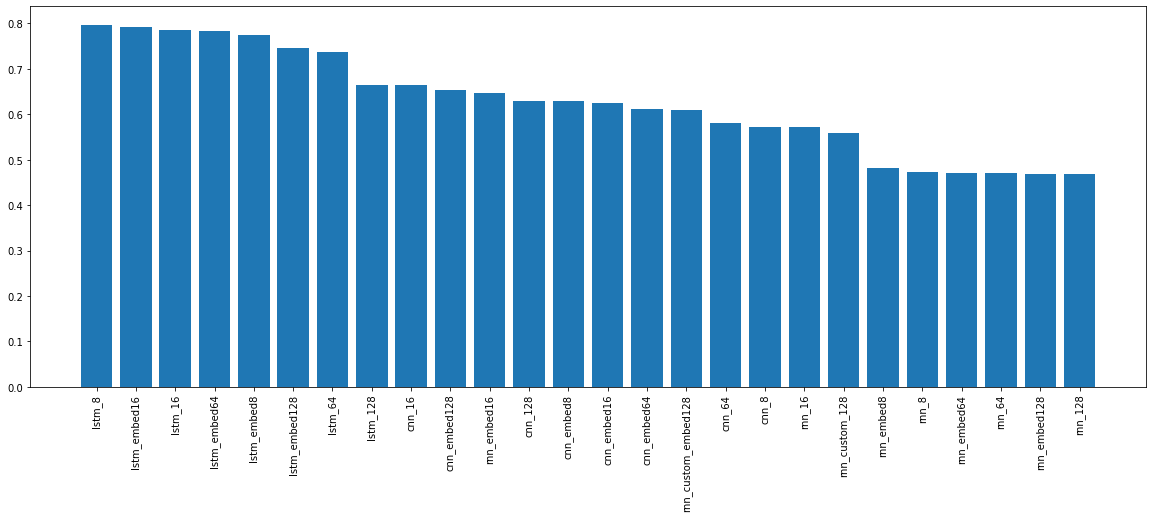

In [123]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.bar(np.array(total_list)[:,0],acc_array)
plt.xticks(rotation=90)
plt.show()

In [68]:
np.array(total_list)[:,0]

array(['lstm_embed128', 'lstm_embed64', 'lstm_embed16', 'lstm_embed8',
       'lstm_128', 'lstm_64', 'lstm_16', 'lstm_8', 'rnn_embed128',
       'rnn_embed64', 'rnn_embed16', 'rnn_embed8', 'rnn_128', 'rnn_64',
       'rnn_16', 'rnn_8', 'rnn_custom_embed128', 'rnn_custom_128',
       'cnn_embed128', 'cnn_embed64', 'cnn_embed16', 'cnn_embed8',
       'cnn_128', 'cnn_64', 'cnn_16', 'cnn_8'], dtype='<U19')